**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2020

# NuScale 720 SMR BoP Simulation Report
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Students:** Jack Kennedy and Nik Kemper <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor:** Prof. Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**12Dec2020**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Objectives](#obj)
* [Approach](#app)
* [Balance of Plant](#bop)
  + [Reactor](#reactor)
  + [Steam Generator](#steamgen)
  + [Turbine](#turbine)
  + [Condenser](#condenser)
  + [Water Heater](#watheater)
  + [Network](#net)
* [Startup, Steady-State, Shutdown](#su-ss-sd)
* [Water Heater Malfunction](#malfunction)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

- As nuclear power continues to find its niche in the energy market, we are seeing an increasing trend towards Small Modular Reactors (SMRs). The benefit to SMRs is their small plant area, modularized reactor design allowing for more cost effective manufacturing, and their low level of operator interaction. 

- The NuScale 720 integral PWR has been under design for close to two decades. The 720 offers a safe design which uses no active components. Instead, the design relies primarily on gravity and natural convection which decreases the maintenance requirements of the system. NuScale Power Modules™ will be manufactured in factories, allowing for a monumental increase in production - the likes of which has never been seen by any other nuclear power plant design. With 2027 being the projected year for the first commercially operated plant, the NuScale 720 looks to become a mainstay in power generation for the U.S. 

- In the NuScale 720 design, the 12 modular reactors are submerged in a pool of water that acts as a heat sink. This pool is designed to respond to reactor conditions by drying up when external power is shut off. This leads to an air cooling mode that can be used in the case of long term (< 30 days) power shutdown. This is the only point where the different reactors influence each other, so it is imperative that each of our cores relates back to this water basin.

- The NuScale 720 has core inlet and outlet coolant temperatures of 265℃ and 321 ℃, respectively. The plant has 12 total reactor modules that split into two turbine buildings, each housing six turbines. Each core produces 200 MWt and 60 MWe for a total capacity to the grid, after considering plant consumption, of 685 MWe. The nominal coolant flow rate for one primary loop is 666 kg/s, whilst the nominal flow rate for the secondary loop is 87 kg/s.

- A balance of plant (BoP) is used to illustrate all components that are involved in energy production. A BoP includes systems like the core, steam generator, turbine, pressurizer, feed water system, and condenser. A BoP can be used to see how each part of the plant plays a role in the overall production of energy. The real time changes of key factors in each part of the reactor, such as changing the control rod level in the reactor, to see how it affects all the other parts of the plant over time. 

## [Objectives](#toc)<a id="obj"></a>

- A BoP will be created for the NuScale 720 reactor system using Python. We will use modules to mimic specific elements such as: the cores, condensers, steam generators, and turbines. A single point kinetics method will be used for modeling the core. A two temperature approach will be used to model the heat transfer meaning we only consider the inlet and outlet temperature of the module. We will be developing the model in Python with the use of the network modeling and HPC simulation library CORTIX. CORTIX will be used in conjunction with the Python modules to allow for dynamic modeling of the plant during start up and shut down of the reactors.

- Our goal for the project is to create a Balance of Plant dynamic system for the NuScale720 12 modular reactor plant. The following accident scenarios will be modeled: melting scenarios, primary loop breaking, and temperature rates during loss of cooling (LOCA) scenarios.

## [Approach](#toc)<a id="app"></a>

- Figure 3 shows how each of the components of our model will feed into each other. The first step to building our model is to outline the inputs, outputs, and equations that govern each individual module in our simulation. Starting at our reactor, information about the tank (such as the level and temperature) go into our reactor module along with instructions from the controller, and feedback from the pressurizer. The reactor then outputs information about the primary loop flow to the steam generator which converts that input information into a steam output. This output steam information is then fed into the turbine system which calculates High, Intermediate, and Low condensate pressures as well as sending excess steam to a condenser that has feedback from a cooling tower. These different condensates from the turbine and the condenser feed into each other until they get to a high pressure feedwater heater tank that outputs information back into the starting reactor.

- A module for the integral plant components including the core, turbine, pressurizer, steam generator, condenser, and feed water system will be modeled using Python. Most information will be obtained from Nuclear Systems Volume 1 and Professor de Almeida’s previous work on making BoP systems for nuclear reactors. 

|     **Module**        |      **Inputs**      |      **Outputs**       |     **Legend**     |
|:----------------------|:---------------------|:-----------------------|:-------------------|
| Core (CR)             |-F,T,P from SG        |-F,T,P, to SG           |-F: Flowrate        |
|                       |-F,T,P from PR        |-F,T,P, to PR           |-T: Temperature     |
|                       |-H from OWP           |-Q to OWP               |-P: Pressure        |
|Pressurizer (PR)       |-F,T,P from CR        |-F,T,P to CR            |-Q: Heat rate       |
|                       |                      |                        |-X: Steam quality   |
|                       |                      |                        |-H: Height          |
|                       |                      |                        |-E: Electrical power|
|Steam Generator (SG)   |-F,T,P from CR and FWS|-F,T,P to CR            |                    |
|                       |                      |-F,T,P,X to TU          |                    |
|Turbine (TU)           |-F,T,P,X from TU      |-E output as electricity|                    |
|                       |                      |-F,T,P,X to CD and FWS  |                    |
|Condenser (CD)         |-F,T,P,X from TU      |-F,T,P to FWS           |                    |
|                       |-Q from cooling tower |                        |                    |
|Feed Water System (FWS)|-F,T,P from CD and TU |-F,T,P to CR            |                    |
|Open Water Pool (OWP)  |-Q from CR            |-H to all CRs           |                    |

- Because we are only a two man group. We will be sharing most of the work and the work will be recorded through weekly progress reports. A schedule of our planned work is shown in table 2.

## [Balance of Plant](#toc)<a id="bop"></a>

In [1]:
'''Setup a Cortix plant'''

from cortix import Cortix
from cortix import Network

plant = Cortix(use_mpi=False, splash=True) # System top level
plant_net = plant.network = Network() # Network

[6484] 2020-12-12 20:40:51,921 - cortix - INFO - Created Cortix object 
_____________________________________________________________________________
                             L A U N C H I N G                               
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%8

### [Reactor](#toc)<a id="reactor"></a>

In [2]:
'''Setup Reactor'''

from bop.reactor import SMPWR
reactor = SMPWR()  # Create reactor module

plant_net.module(reactor)  # Add reactor module to network

### [Steam Generator](#toc)<a id="steamgen"></a>

The steam generator is modeled as a countercurrent heat exchanger using the number of of transfer units (NTU) where $\mathrm{NTU} \equiv \frac{\mathrm{UA}}{\mathrm{C}_{\mathrm{min}}}$. 

The heat transfer rate is given by $\mathrm{q}=\varepsilon \mathrm{C}_{\min }\left(\mathrm{T}_{\mathrm{h}, \mathrm{i}}-\mathrm{T}_{\mathrm{c}, \mathrm{i}}\right)$ where $C_{\mathrm{r}}=\frac{\mathrm{C}_{\mathrm{min}}}{\mathrm{C}_{\max }}$ and $C_{j}=\dot{\mathrm{m}}_{j} c_{p, j}$. 

The effectiveness, $\varepsilon$ , for a countercurrent heat exchanger is given by $\varepsilon=\frac{1-\exp \left[-\mathrm{NTU}\left(1-C_{r}\right)\right]}{1-C_{r} \exp \left[-\mathrm{NTU}\left(1-C_{r}\right)\right]}$ and is valid for $\left(C_{r}<1\right)$. 

Given the inlet temperatures the primary outlet temperature can be solved for from $\mathrm{T}_{\mathrm{h}, \mathrm{o}}=\mathrm{T}_{\mathrm{h}, \mathrm{i}^{-}} \frac{\mathrm{q}}{\mathrm{C}_{\mathrm{hot}}}$ and the seconday outlet temperature from $\mathrm{T}_{\mathrm{c}, \mathrm{o}}=\mathrm{T}_{\mathrm{c}, \mathrm{i}}+\frac{\mathrm{q}}{\mathrm{C}_{\text {cold }}}$

##### Calculated paramters/ constants: 

$\mathrm{C}_{\mathrm{hot}}=3729.7 \mathrm{~kW} / \mathrm{K}$

$\mathrm{C}_{\mathrm{cold}}=1110.5 \mathrm{~kW} / \mathrm{K}$

$c_{p, \text { primary }}=5.6000 \mathrm{~kJ} / \mathrm{kg}-\mathrm{K}$

$c_{p, \text { seconary }}=4.2980 \mathrm{~kJ} / \mathrm{kg}-\mathrm{K}$

Where all properties are assumed to be constant and $C_{\text {cold }}$ is a ficticious value in order to account for phase change. The actual secondary side outlet tempeprature is calculated from $\mathrm{T}_{\mathrm{c}, \mathrm{o}}=\mathrm{T}_{\mathrm{c}, \mathrm{i}}+\frac{\mathrm{q}}{\mathrm{C}_{\text {cold }}}$ , $\mathrm{q}_{\text {secondary }}=\mathrm{C}_{\text {cold }}\left(\mathrm{T}_{\mathrm{c}, \mathrm{o}}-\mathrm{T}_{\mathrm{c}, \mathrm{i}}\right)$, and separating the secondary side coolant into liquid heating, vaporizing, and gas heating sections.

$\Delta \mathrm{H}_{\mathrm{vap}}=1765.4 \mathrm{~kJ} / \mathrm{kg} @ 513 \mathrm{~K}$

$\mathrm{T}_{\mathrm{sat}}=516 \mathrm{~K}$

The gas heat capacity is given by $\int_{\mathrm{Tsat}}^{\mathrm{T}} \frac{\mathrm{c}_{\mathrm{p}}}{\mathrm{R}} \mathrm{dT}=\mathrm{A}\left(\mathrm{T}-\mathrm{T}_{\mathrm{sat}}\right)-\frac{\mathrm{B}}{2}\left(\mathrm{~T}^{2}-\mathrm{T}_{\mathrm{sat}}^{2}\right)$

where, for water, A = 3.470 and B = 1.450*$10^{3}$

In [3]:
'''Setup Steamer'''

from bop.steamer import Steamer
steamer = Steamer()  # Create steamer module

plant_net.module(steamer)  # Add steamer module to network

### [Turbine](#toc)<a id="turbine"></a>

In [4]:
'''Setup Turbine'''

from bop.turbine import Turbine
turbine = Turbine()  # Create turbine module

plant_net.module(turbine)  # Add turbine module to network

### [Condenser](#toc)<a id="condenser"></a>

In [5]:
'''Setup Condenser'''

from bop.condenser import Condenser
condenser = Condenser()  # Create condenser module

plant_net.module(condenser)  # Add condenser module to network

### [Water Heater](#toc)<a id="watheater"></a>

In [6]:
'''Setup Water Heater system'''

from bop.water_heater import WaterHeater
water_heater = WaterHeater()  # Create water_heater module

plant_net.module(water_heater)  # Add water_heater module to network

### [Network](#toc)<a id="net"></a>

In [7]:
'''Balance of Plant Network Connectivity'''

plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
plant_net.connect([turbine, 'outflow'], [condenser, 'inflow'])
plant_net.connect([turbine, 'process-heat'], [water_heater, 'external-heat'])
plant_net.connect([condenser, 'outflow'], [water_heater, 'inflow'])
plant_net.connect([water_heater, 'outflow'], [steamer, 'secondary-inflow'])

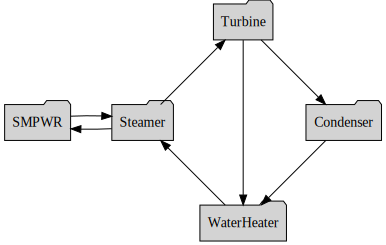

In [8]:
plant_net.draw(engine='circo', node_shape='folder')

## [Startup, Steady State, and Shutdown](#toc)<a id="su-ss-sd"></a>

This is a time-consuming run, typically ~15 to 30 minutes (depending on the machine this is running on; load on the machine, etc.). The steam/water property calculations consume a big portion of the runtime. This is a point of improvement for the future.

In [9]:
'''Run'''

import unit
end_time = 75*unit.minute 
time_step = 1.5*unit.second
show_time = (True, 5*unit.minute)

for module in plant_net.modules:
    module.time_step = time_step
    module.end_time = end_time
    module.show_time = show_time

reactor.shutdown = (True, 60*unit.minute)

plant.run()   # Run network dynamics simulation
plant.close() # Close run

[6484] 2020-12-12 20:40:52,625 - cortix - INFO - Launching Module <bop.reactor.SMPWR object at 0x7fda8377b0a0>
[6484] 2020-12-12 20:40:52,646 - cortix - INFO - Launching Module <bop.steamer.Steamer object at 0x7fda861bc160>
[6484] 2020-12-12 20:40:52,657 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7fda8371d100>
[6484] 2020-12-12 20:40:52,671 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7fda861cadf0>
[6484] 2020-12-12 20:40:52,686 - cortix - INFO - Launching Module <bop.water_heater.WaterHeater object at 0x7fda861d8a60>
[6484] 2020-12-12 20:54:02,666 - cortix - INFO - run()::Elapsed wall clock time [s]: 790.74
[6484] 2020-12-12 20:54:02,667 - cortix - INFO - Closed Cortix object.
_____________________________________________________________________________
                           T E R M I N A T I N G                             
_____________________________________________________________________________
      ...                  

In [10]:
reactor = plant_net.modules[0]
steamer = plant_net.modules[1]

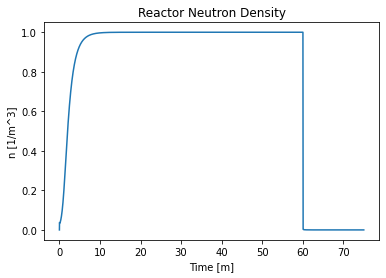

In [11]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('neutron-dens')
quant.plot(x_scaling=1/unit.minute, y_scaling=1/max(quant.value), x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

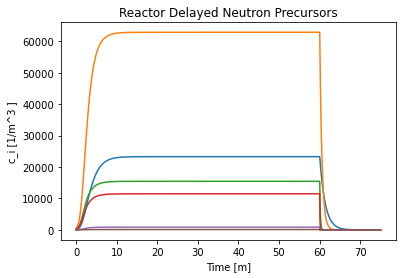

In [12]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('delayed-neutrons-cc')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

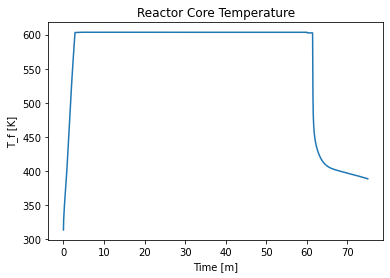

In [13]:
(quant, time_unit) = reactor.state_phase.get_quantity_history('core-temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

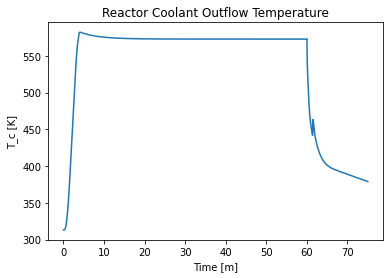

In [14]:
(quant, time_unit) = reactor.coolant_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

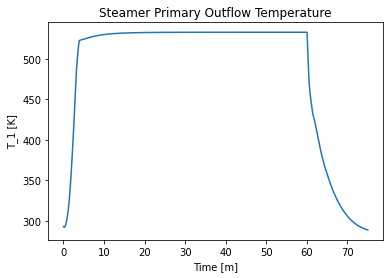

In [15]:
(quant, time_unit) = steamer.primary_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

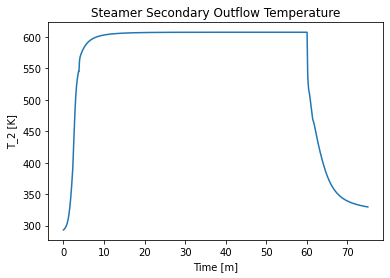

In [16]:
(quant, time_unit) = steamer.secondary_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

## [Water Heater Malfunction](#toc)<a id="malfunction"></a>

In [17]:
'''Rebuild System'''

plant = Cortix(use_mpi=False, splash=True) # System top level
plant_net = plant.network = Network() # Network

reactor = SMPWR()  # Create reactor module
plant_net.module(reactor)  # Add reactor module to network

steamer = Steamer()  # Create steamer module
plant_net.module(steamer)  # Add steamer module to network

turbine = Turbine()  # Create turbine module
plant_net.module(turbine)  # Add turbine module to network

condenser = Condenser()  # Create condenser module
plant_net.module(condenser)  # Add condenser module to network

water_heater = WaterHeater()  # Create water_heater module
plant_net.module(water_heater)  # Add water_heater module to network

plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
plant_net.connect([turbine, 'outflow'], [condenser, 'inflow'])
plant_net.connect([turbine, 'process-heat'], [water_heater, 'external-heat'])
plant_net.connect([condenser, 'outflow'], [water_heater, 'inflow'])
plant_net.connect([water_heater, 'outflow'], [steamer, 'secondary-inflow'])

[6484] 2020-12-12 20:54:03,914 - cortix - INFO - Created Cortix object 
_____________________________________________________________________________
                             L A U N C H I N G                               
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%8

In [18]:
'''Run with malfunction of water heater'''

import unit
end_time = 75*unit.minute 
time_step = 1.5*unit.second
show_time = (True, 5*unit.minute)

for module in plant_net.modules:
    module.time_step = time_step
    module.end_time = end_time
    module.show_time = show_time

reactor.shutdown = (True, 60*unit.minute)

water_heater.malfunction = (True, 30*unit.minute, 45*unit.minute)

plant.run()   # Run network dynamics simulation
plant.close() # Close run

[6484] 2020-12-12 20:54:03,951 - cortix - INFO - Launching Module <bop.reactor.SMPWR object at 0x7fda8377b580>
[6484] 2020-12-12 20:54:03,957 - cortix - INFO - Launching Module <bop.steamer.Steamer object at 0x7fda86805040>
[6484] 2020-12-12 20:54:03,967 - cortix - INFO - Launching Module <bop.turbine.Turbine object at 0x7fda866911c0>
[6484] 2020-12-12 20:54:03,977 - cortix - INFO - Launching Module <bop.condenser.Condenser object at 0x7fda84ce8130>
[6484] 2020-12-12 20:54:03,990 - cortix - INFO - Launching Module <bop.water_heater.WaterHeater object at 0x7fda85b57e50>
[6484] 2020-12-12 21:09:45,904 - cortix - INFO - run()::Elapsed wall clock time [s]: 941.99
[6484] 2020-12-12 21:09:45,905 - cortix - INFO - Closed Cortix object.
_____________________________________________________________________________
                           T E R M I N A T I N G                             
_____________________________________________________________________________
      ...                  

## [References](#toc)<a id="refs"></a>

- [1] J. Kennedy, N. Kemper, V. F. de Almeida, [Engy-4390: Small Modular Pressurized Water Reactor](https://github.com/dpploy/engy-4390/tree/main/projects/sm-pwr).
- [2] Dale Atkinson, “NuScale update for NASEO” Nuscale power, May 2019. Retrieved at:https://naseo.org/Data/Sites/1/atkinson_naseo-may-22,-2019.pdf 
- [3] V. F. de Almeida, [Cortix](https://cortix.org), *Network Dynamics Simulation*, University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear program).
- [4] V. F. de Almeida, [*Engy-4350: Nuclear Reactor Engineering*](https://github.com/dpploy/engy-4350), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Program).
- [5] NuScale, "NuScale Standard PlantDesign Certification Application, Chapter Four, Reactor, Revision 5", July 2020.Retrieved at:https://www.nrc.gov/docs/ML2022/ML20224A492.pdf
- [6] NuScale, "NuScale Standard PlantDesign Certification Application, Chapter Five, Reactor Coolant Systems and Connecting Systems, Revision 5", July 2020.Retrieved at:https://www.nrc.gov/docs/ML2022/ML20224A493.pdf
- [7] NuScale, "NuScale Standard PlantDesign Certification Application, Chapter Ten, Steam and Power Conversion System, Revision 5", July 2020.Retrieved at:https://www.nrc.gov/docs/ML2022/ML20224A499.pdf